Here is some sample python code for reproducing figures in the "Distributional Data Analysis" chapter. First we need to import a few packages. matplotlib.pyplot is generally for plotting, while numpy is a package that lets us use arrays in python. xarray is a package based on dataframes from the popular pandas package which is specialised to handle netCDF files. We import scipy.stats for our binned statistics function. Basemap lets us plot continents on different projections of the globe. time is used to time our code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats
from mpl_toolkits.basemap import Basemap
import time

First we will import the dataset to take a look at it using xarray.

In [26]:
datadir = "../data/"
ds = xr.open_dataset(datadir + "floats.nc")
print(ds.head())

<xarray.Dataset>
Dimensions:  (column: 5, segment: 5)
Dimensions without coordinates: column, segment
Data variables:
    expid    (segment) float64 ...
    typeid   (segment) float64 ...
    id       (segment) float64 ...
    num      (column) float64 ...
    lat      (column) float64 ...
    lon      (column) float64 ...
    u        (column) float64 ...
    v        (column) float64 ...
    p        (column) float64 ...
    t        (column) float64 ...
    filled   (column) float64 ...
Attributes:
    title:      FLOATS.NC subsurface float dataset
    link:       http://www.aoml.noaa.gov/phod/float_traj/data.php
    about:      For more information, see ABOUT_FLOATS.M.
    note:       In Matlab, try 'ncload floats' using jLab routine ncload.
    creator:    J. M. Lilly
    timestamp:  13-Jan-2019 16:46:27


We see that we have a data set with many different variables and two dimensons: column and segment. For now we will plot the latitude and longitude coordinates. As they aren't coordinates in the data set it's easiest to extract the numpy arrays from the data set.

In [27]:
lon = ds.lon.values
lat = ds.lat.values

Now that we have our data we can use Basemap to plot the continents. Plotting in python is object-oriented, so we will begin by creating Figure and Axes objects. Basemap is itself an Axes object so we can update our original Axes object by calling it.

<IPython.core.display.Javascript object>


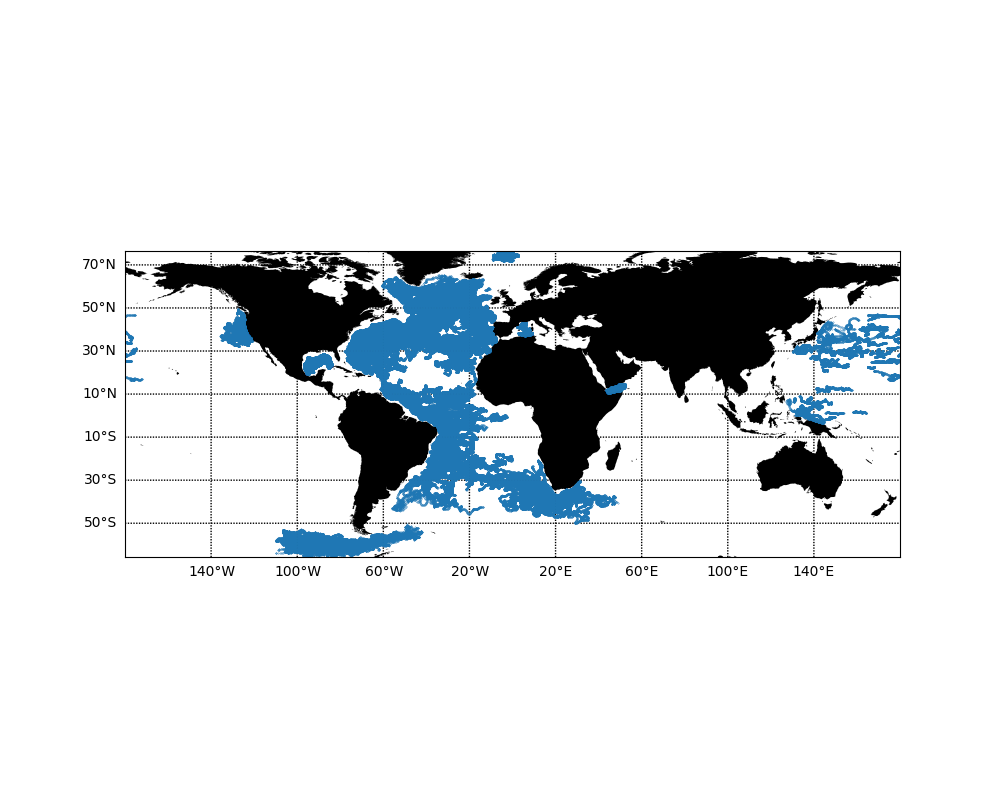

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#ax.set_aspect("equal")  # Setting the aspect ratio to be equal

map = Basemap(  ax=ax,  # Create new ax called map with these configurations
                llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon),  # Lower and upper bounds
                llcrnrlat=np.nanmin(lat), urcrnrlat=np.nanmax(lat),
                projection="cyl",  # Cylindrical projection
                fix_aspect=True,  # We want the aspect ratio to remain equal
                resolution='l'  # c - crude, l - low, i - intermediate, h - high, f - full
             )
map.fillcontinents(color="black", lake_color="black")
map.drawparallels(np.arange(-90, 90, 20), labels=[1, 0, 0, 0])
map.drawmeridians(np.arange(-180, 180, 40), labels=[1, 0, 0, 1])

map.plot(lon, lat, latlon=True, marker=".", linestyle=" ", markersize=0.5)
#ds.plot.scatter(x="lon", y="lat", ax=ax)

Note that we always have to specify our Basemap configuration. If you're making a lot of similar plots it can be wise to create a wrapper function with configurations to make the code more readable. Higher resolution Basemaps look nice but significantly increases runspeed. Low is a decent compromise. We now want to create some histograms. First of all we would like to look at the trajectory count in the northern atlantic ocean. To begin we create appropriate bins.

In [6]:
lonbins = np.arange(-80, 0, 0.5)
latbins = np.arange(15, 65, 0.5)

We then create the histogram and plot it. As the function returns the edges of each bin we need to construct the central points of each bin.

RUNTIME: 0.07761913000000042 s


<IPython.core.display.Javascript object>


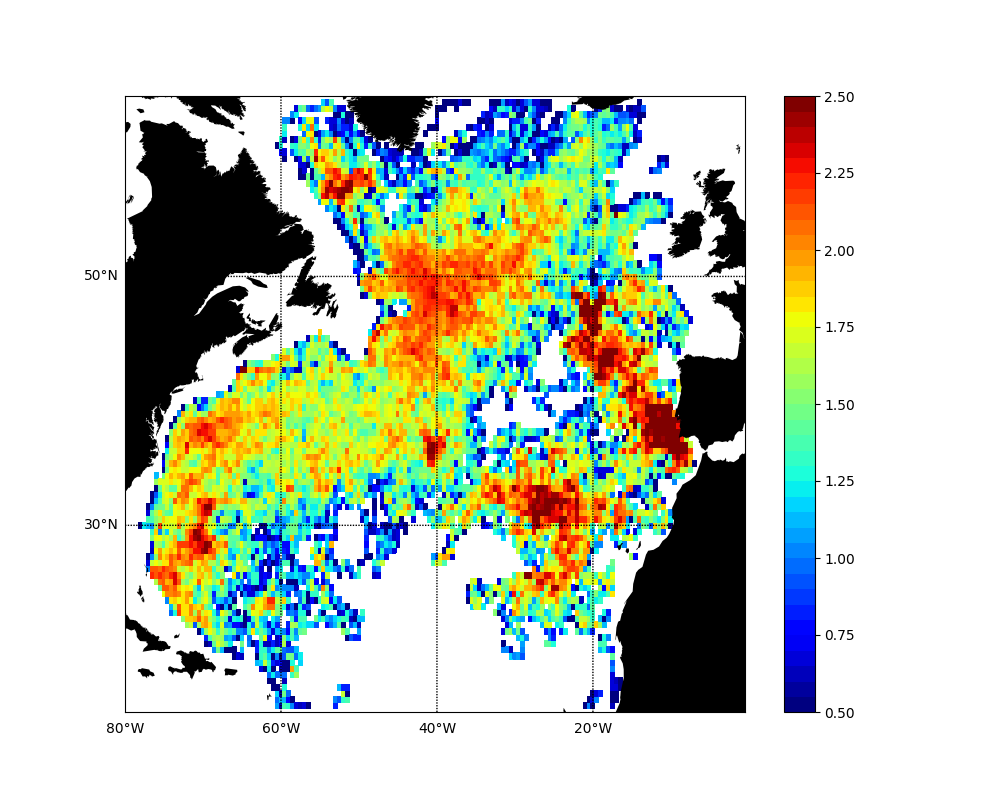

In [7]:
start = time.process_time()
hist = stats.binned_statistic_2d(lon, lat, None, bins=[lonbins, latbins], statistic="count")  # Returns a object
end = time.process_time()
print("RUNTIME:", end - start, "s")

loncenter = 0.5*(hist.x_edge[1:] + hist.x_edge[:-1])  # Skipping first edge and last edge respectively
latcenter = 0.5*(hist.y_edge[1:] + hist.y_edge[:-1])
LON, LAT = np.meshgrid(loncenter, latcenter, indexing="ij")  # 2D meshgrid of our bins with specified indexing

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal")

map = Basemap(  ax=ax,
                llcrnrlon=lonbins[0], urcrnrlon=lonbins[-1],
                llcrnrlat=latbins[0], urcrnrlat=latbins[-1],
                projection="cyl",
                fix_aspect=False,
                resolution='l'
            )
map.fillcontinents(color="black", lake_color="black")
map.drawparallels(np.arange(-90, 90, 20), labels=[1, 0, 0, 0])
map.drawmeridians(np.arange(-180, 180, 20), labels=[1, 0, 0, 1])


hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
cmap = plt.cm.get_cmap("jet", 40)
im = map.pcolormesh(LON, LAT, np.log10(hist.statistic),
                    vmin=0.5,
                    vmax=2.5,
                    cmap=cmap,
                    shading="flat",
                    latlon=True  # Specifying that coordinates are latitudes and longitudes
                    )

fig.colorbar(im, ax=ax)  # creating a colorbar attached to the ax

stats.binned_statistic_2d() is the central function in the code snippet. The third input is simply None since we are only interested in the count in each bin specified by statistic="count". This slightly weird syntax is due to the function using a numpy function numpy.histogram2d() to create histograms and calculate statistics. We could simply use histogram2d() in this case since we aren't interested in statistics, but for consistency we will only use the one function.

Now we want to plot the speeds in each bin. To do that we first need the speed. Looking back we see that we have access to both components of the velocity vector, and so we only need to calculate the magnitude of the velocity. Again we start by extracting the velocities.

In [8]:
u = ds.u.to_masked_array()  # In case the variables are masked
v = ds.v.to_masked_array()
speed = np.sqrt(u**2 + v**2)

Now we can use the bins and meshgrid from earlier, so the code becomes

RUNTIME: 0.07583910700000018 s


<IPython.core.display.Javascript object>


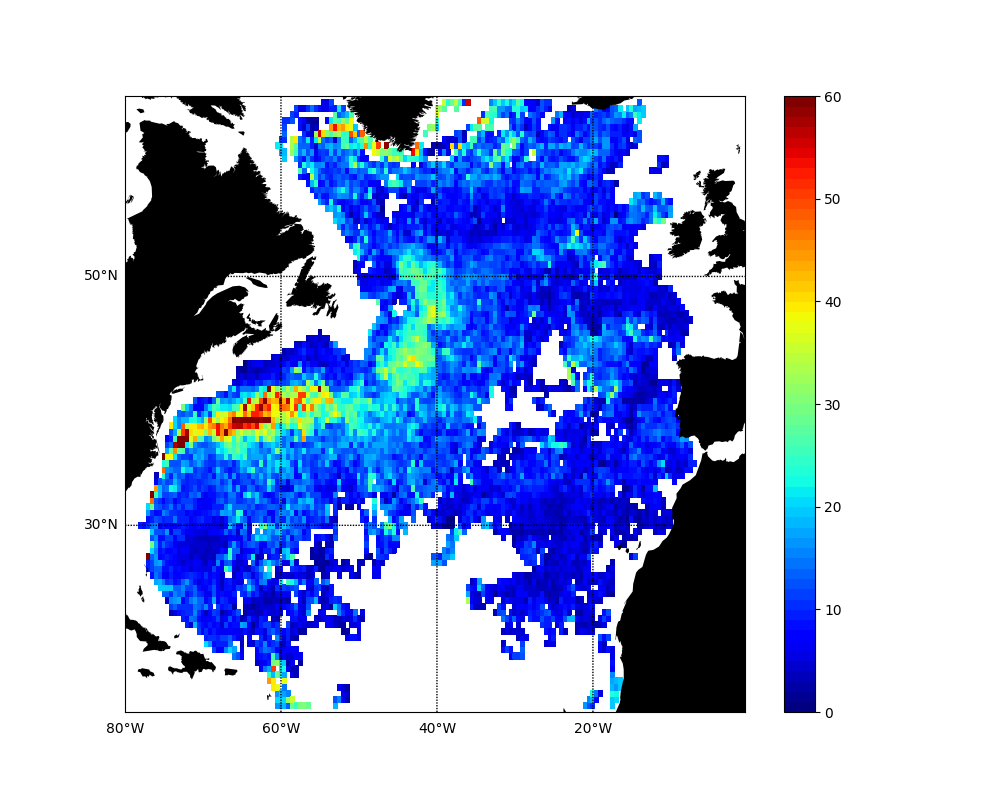

In [10]:
start = time.process_time()
mean = stats.binned_statistic_2d(lon, lat, speed, bins=[lonbins, latbins], statistic="mean")  # mean is specified
end = time.process_time()
print("RUNTIME:", end - start, "s")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal")

map = Basemap(  ax=ax,
                llcrnrlon=lonbins[0], urcrnrlon=lonbins[-1],
                llcrnrlat=latbins[0], urcrnrlat=latbins[-1],
                projection="cyl",
                fix_aspect=False,
                resolution='l'
            )
map.fillcontinents(color="black", lake_color="black")
map.drawparallels(np.arange(-90, 90, 20), labels=[1, 0, 0, 0])
map.drawmeridians(np.arange(-180, 180, 20), labels=[1, 0, 0, 1])

cmap = plt.cm.get_cmap("jet", 60)
im = map.pcolormesh(LON, LAT, mean.statistic,
                    vmin=0,
                    vmax=60,
                    cmap=cmap,
                    shading="flat",
                    latlon=True  # Specifying that coordinates are latitudes and longitudes
                    )

fig.colorbar(im, ax=ax)  # creating a colorbar attached to the ax

Note that speed has replaced None as input. For the standard deviation all we have to change is the statistic keyword argument. I also choose to make all zeros nan as they aren't that interesting. The best way to do this is with a mask so that we don't change the underlying data, but for our purposes it suffices. If I hadn't done this the background would be all blue.

RUNTIME:  0.08742101800000057 s


<IPython.core.display.Javascript object>


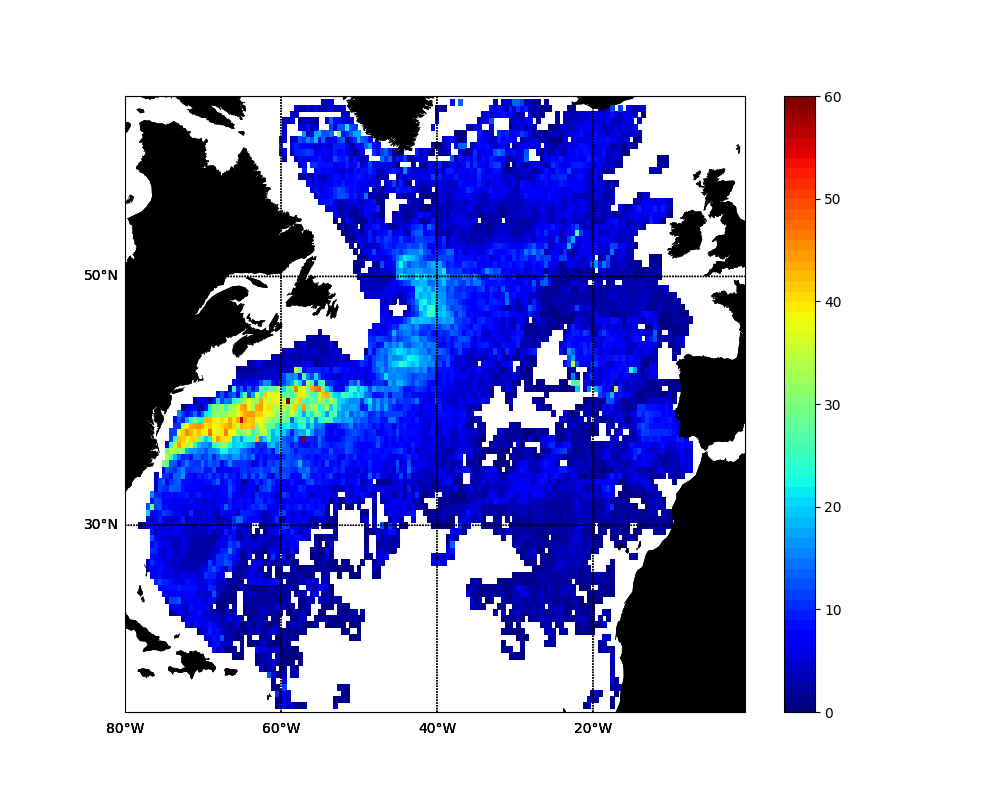

In [48]:
start = time.process_time()
std = stats.binned_statistic_2d(lon, lat, speed, bins=[lonbins, latbins], statistic="std")  # std is specified
end = time.process_time()
print("RUNTIME:", end - start, "s")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal")

map = Basemap(  ax=ax,
                llcrnrlon=lonbins[0], urcrnrlon=lonbins[-1],
                llcrnrlat=latbins[0], urcrnrlat=latbins[-1],
                projection="cyl",
                fix_aspect=False,
                resolution='l'
            )
map.fillcontinents(color="black", lake_color="black")
map.drawparallels(np.arange(-90, 90, 20), labels=[1, 0, 0, 0])
map.drawmeridians(np.arange(-180, 180, 20), labels=[1, 0, 0, 1])

std.statistic[std.statistic == 0] = np.nan
cmap = plt.cm.get_cmap("jet", 60)
im = map.pcolormesh(LON, LAT, std.statistic,
                    vmin=0,
                    vmax=60,
                    cmap=cmap,
                    shading="flat",
                    latlon=True  # Specifying that coordinates are latitudes and longitudes
                    )

fig.colorbar(im, ax=ax)  # creating a colorbar attached to the ax

We can also look at where the highest speed are in the water column. To do this we extract the pressure. We'll use the latitude bins from earlier, but create pressure bins. Calculating the mean is then just business as usual.

RUNTIME: 0.08805187599999442 s


<IPython.core.display.Javascript object>


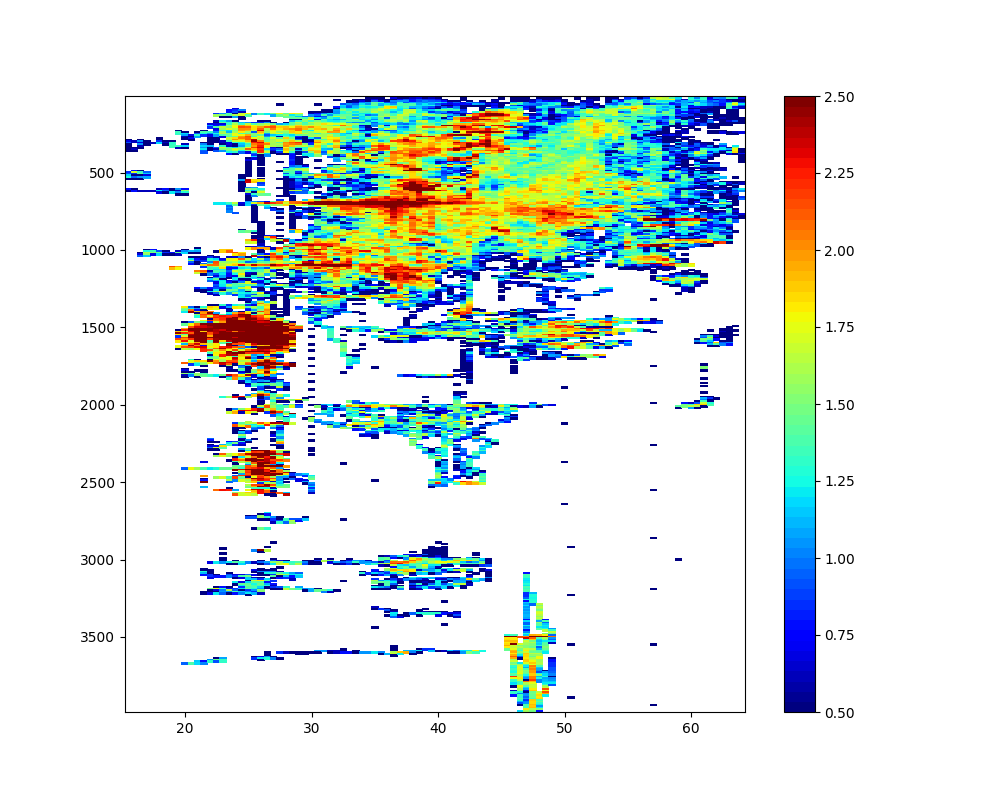

In [58]:
p = ds.p.to_masked_array()

pbins = np.arange(0, 4000, 10)

start = time.process_time()
phist = stats.binned_statistic_2d(lat, p, None, bins=[latbins, pbins], statistic="count")
end = time.process_time()
print("RUNTIME:", end - start, "s")

latcenter = 0.5*(phist.x_edge[1:] + phist.x_edge[:-1])  # Skipping first edge and last edge respectively
pcenter = 0.5*(phist.y_edge[1:] + phist.y_edge[:-1])
LAT, P = np.meshgrid(latcenter, pcenter, indexing="ij")  # 2D meshgrid of our bins with specified indexing

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

phist.statistic[phist.statistic == 0] = np.nan
cmap = plt.cm.get_cmap("jet", 60)
im = ax.pcolormesh(LAT, P, np.log10(phist.statistic),
                    vmin=0.5,
                    vmax=2.5,
                    cmap=cmap,
                    shading="flat",
                    )

fig.colorbar(im, ax=ax)  # creating a colorbar attached to the ax
ax.invert_yaxis()

Again, we can look at the mean of the speed.

RUNTIME: 0.10374488200000087 s


<IPython.core.display.Javascript object>


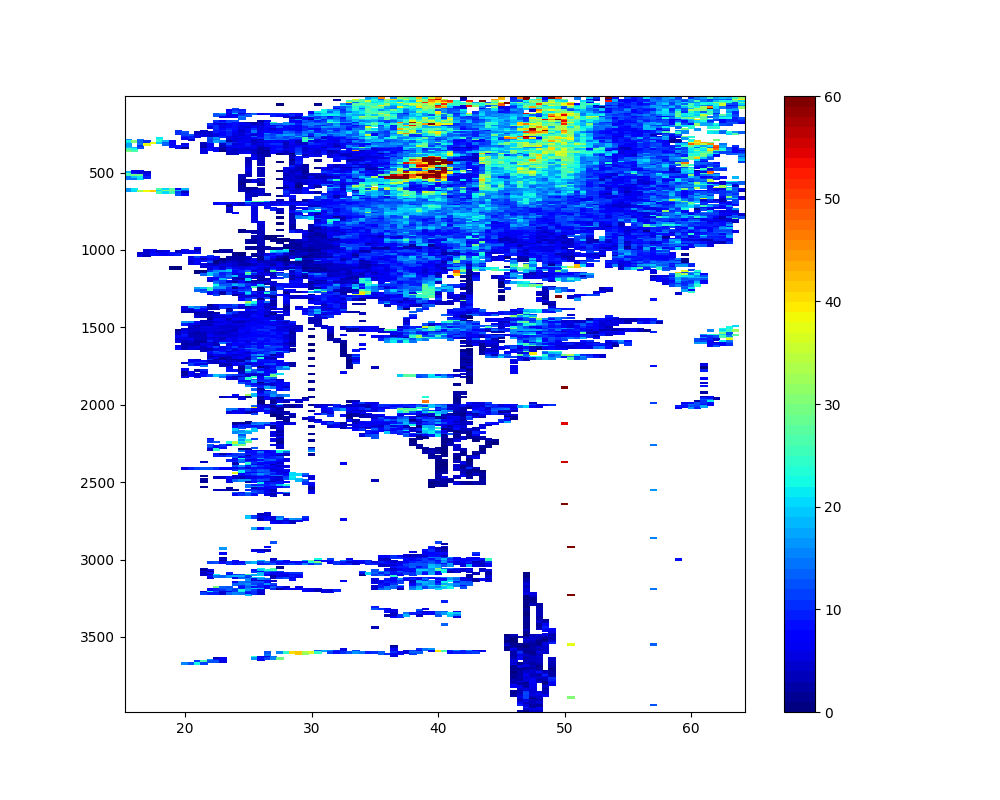

In [64]:
start = time.process_time()
pmean = stats.binned_statistic_2d(lat, p, speed, bins=[latbins, pbins], statistic="mean")  # mean is specified
end = time.process_time()
print("RUNTIME:", end - start, "s")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cmap = plt.cm.get_cmap("jet", 60)
im = ax.pcolormesh(LAT, P, pmean.statistic,
                    vmin=0,
                    vmax=60,
                    cmap=cmap,
                    shading="flat",
                    )

fig.colorbar(im, ax=ax)  # creating a colorbar attached to the ax
ax.invert_yaxis()